# Physical models implemented in PICSAR-QED module

In [1]:
import numpy as np
import scipy.special as spe
import scipy.integrate as integ
import matplotlib.pyplot as plt

from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


## Some useful physical constants (according to CODATA 2018)
#### Warning : SI units will be used in the whole notebook

In [2]:
# for CODATA 2018 see: https://physics.nist.gov/cuu/Constants/index.html

me = 9.1093837015e-31 #electron mass
c = 299792458 #speed of light
hbar = 6.62607015e-34/(2*np.pi) #reduced Plank constant
fine_structure = 7.2973525693e-3 #fine structure constant
qe = 1.602176634e-19#elementary charge
E_s = (me**2 * c**3)/(qe * hbar) #Schwinger E field
B_s = E_s/c #Schwinger B field

mec = me*c

#This function gives the electric field (SI units) of a laser of wavelength wlg and intensity a0:
def get_electric_field(wlg, a0):
    return a0 * me * c**2 *2.0 *np.pi/(wlg*qe)

#### Some quick checks (Schwinger field should be ~ 1.3e18 V/m):

In [3]:
print("Schwinger field : {:6.3e} V/m".format(E_s))
print("Magnetic Schwinger field : {:6.3e} T".format(B_s))
print("Field of a laser having λ=800nm and a0=1 : {:6.3e} V/m".format(get_electric_field(800e-9, 1)))

Schwinger field : 1.323e+18 V/m
Magnetic Schwinger field : 4.414e+09 T
Field of a laser having λ=800nm and a0=1 : 4.013e+12 V/m


## χ parameter for photons, electrons and positrons

The quantum parameters for electrons (or positrons) χ and the quantum parameter χ\_phot for photons are defined as in [Smilei documentation](https://smileipic.github.io/Smilei/radiation\_loss.html):

$$
\chi = \frac{\vert F_{\mu \nu} p^{\nu} \vert}{E_s m_e c} = \frac{\gamma}{E_s} \sqrt{\left({\mathbf{E} +\mathbf{v} \times \mathbf{B}}\right)^2 - \left({\frac{\mathbf{v} \cdot\mathbf{E}}{c}}\right)^2}
$$

$$
\chi_{\gamma} = \frac{\vert F_{\mu \nu} p^{\nu} \vert}{E_s m_e c} = \frac{\gamma_{\gamma}}{E_s} \sqrt{\left({\mathbf{E} +\mathbf{c} \times \mathbf{B}}\right)^2 - \left({\frac{\mathbf{c} \cdot\mathbf{E}}{c}}\right)^2}
$$

where ${\gamma_{\gamma}} = \dfrac{\vert\mathbf{p c}\vert}{m_e c^2}$ is a normalization of the photon energy. Note that in the ultra-relativistic limit $\chi_\gamma / \chi \sim \gamma_\gamma / \gamma$.

It is worth to point out that the notation is different with respect to that adopted in [KirkPPCF2009](https://doi.org/10.1088/0741-3335/51/8/085008), [DuclousPPCF2011](https://doi.org/10.1088/0741-3335/53/1/015009) and [RidgersJCP2014](https://doi.org/10.1016/j.jcp.2013.12.007), where $\chi \rightarrow \eta$ and $\chi_{\gamma} \rightarrow 2\chi$

In [4]:
# p, E, B in SI units with shape (N, 3)
def comp_chi_phot(p, E, B):
    gamma_phot = np.linalg.norm(p, axis=1)/mec  
    c = p/gamma_phot[:,None]
    cdotE = np.einsum('ij,ij->i',c,E)
    ccrossB = np.cross(c,B)
    loc_field = gamma_phot * np.linalg.norm( E - cdotE[:,None]*c + ccrossB, axis=1)     
    return loc_field/E_s

# p, E, B in SI units with shape (3)
def comp_single_chi_phot(p,E,B):
    return comp_chi_phot(p[None,:], E[None,:], B[None,:])[0]


# p, E, B in SI units with shape (N, 3)
def comp_chi_ele_pos(p, E, B):
    p = p/mec
    gamma = np.sqrt(1.0 + np.einsum('ij,ij->i',p,p))
    b = np.einsum('ij,i->ij',p,1./gamma)
    v = c*b
    bdotE = np.einsum('ij,ij->i',b,E)
    evcb = E + np.cross(v,B)
    loc_field = gamma * np.sqrt(np.abs(bdotE**2 -  np.einsum('ij,ij->i',evcb,evcb)))
    return loc_field/E_s

# p, E, B in SI units with shape (3)
def comp_single_chi_ele_pos(p,E,B):
    return comp_chi_ele_pos(p[None,:], E[None,:], B[None,:])[0]

#### Some quick tests:

In [131]:
pp = mec
ee = E_s

chi_phot = comp_single_chi_phot(np.array([pp, 0, 0]), np.array([0, ee, 0]), np.array([0,0,0]))
print("χ_phot for px = {:6.2e} me*c, Ey = {:6.2e} E_s, B = 0 T -->  {:6.4e}".format(pp/mec, ee/E_s,chi_phot))

chi_ele = comp_single_chi_ele_pos(np.array([pp, 0, 0]), np.array([0, ee, 0]), np.array([0,0,0]))
print("χ_ele for px = {:6.2e} me*c, Ey = {:6.2e} E_s, B = 0 T -->  {:6.4e}".format(pp/mec, ee/E_s, chi_ele))

χ_phot for px = 1.00e+00 me*c, Ey = 1.00e+00 E_s, B = 0 T -->  1.0000e+00
χ_ele for px = 1.00e+00 me*c, Ey = 1.00e+00 E_s, B = 0 T -->  1.4142e+00


## Breit-Wheeler (BW) pair generation

For the Breit-Wheeler pair production process, the model described in [Smilei documentation](https://smileipic.github.io/Smilei/multiphoton\_Breit\_Wheeler.html) is adopted. Essentially _Ritus formulae_ are used.

Other useful references are:
- [NikishovJETP1964](http://www.jetp.ac.ru/cgi-bin/dn/e_019_02_0529.pdf)
- [ErberRevModPhys1966](https://doi.org/10.1103/RevModPhys.38.626)
- [BaierJETP1968](http://www.jetp.ac.ru/cgi-bin/dn/e_026_04_0854.pdf)
- [RitusPhDThesis1985](https://link.springer.com/article/10.1007/BF01120220)
- [KirkPPCF2009](https://doi.org/10.1088/0741-3335/51/8/085008)
- [DuclousPPCF2011](https://doi.org/10.1088/0741-3335/53/1/015009)
- [RidgersJCP2014](https://doi.org/10.1016/j.jcp.2013.12.007)
- [GonoskovPRE2015](https://doi.org/10.1103/PhysRevE.92.023305)
- [LobetPhdThesis2016](https://tel.archives-ouvertes.fr/tel-01314224)
- [LobetJPhysConf2016](https://doi.org/10.1088/1742-6596/688/1/012058)
- [Smilei external QED lookup tables](https://smileipic.github.io/Smilei/tables.html)

The following expression is used for the differential pair production cross section:

$$
\dfrac{d^2N}{dt d\chi_-} = \frac{\alpha_{f} m_e c^2}{\pi \sqrt{3} \hbar \gamma_\gamma \chi_\gamma} \int_{X(\chi_\gamma, \chi_-)}^{+\infty} \sqrt{s} K_{1/3}\left({\frac{2}{3} s^{3/2}}\right) ds - (2 - \chi_\gamma X^{3/2}(\chi_\gamma, \chi_-)) K_{2/3}\left({\frac{2}{3} X^{3/2}(\chi_\gamma, \chi_-)}\right)
$$
where $X(\chi_\gamma, \chi_-) = (\chi_\gamma/(\chi_+ \chi_-))^{2/3}$ ($\chi_+$, the $\chi$ parameter of the emitted positron, can be rewritten as $\chi_+ = \chi_\gamma - \chi_-$).

The previous formula can be re-written as:

$$
\dfrac{d^2N}{dt d\chi_-} = \frac{\alpha_{f} m_e c^2}{\hbar \gamma_\gamma} \chi_\gamma F(\chi_\gamma, \chi_-)
$$

We can obtain the total cross section by integrating over $\chi_-$ from $0$ up to $\chi_\gamma$.

$$
\dfrac{dN}{dt} = \frac{\alpha_{f} m_e c^2}{\hbar \gamma_\gamma} \chi_\gamma T(\chi_\gamma)
$$

where

$$
 T(\chi_\gamma) = \int_0^{\chi_\gamma} F(\chi_\gamma, u) du = \int_0^{\chi_\gamma} \dfrac{1}{\pi \sqrt{3}\chi_\gamma^2} \int_{X(\chi_\gamma, u)}^{+\infty} \sqrt{s} K_{1/3}\left({\frac{2}{3} s^{3/2}}\right) ds - (2 - \chi_\gamma X^{3/2}(\chi_\gamma, u)) K_{2/3}\left({\frac{2}{3} X^{3/2}(\chi_\gamma, u)}\right) du
$$

It is noteworthy that a very good simple approximation exists for $T(\chi_\gamma)$ (see [ErberRevModPhys1966](https://doi.org/10.1103/RevModPhys.38.626) ):

$$
 T(\chi_\gamma) \quad \sim \quad 0.16 \frac{K^2_{1/3}(2/(3 \chi_\gamma))}{\chi_\gamma} \quad \sim \quad     \begin{cases} 
      \exp(-2/(3 \chi_\gamma)) & \chi_\gamma \ll 1 \\
      \chi_\gamma^{-1/3} & \chi_\gamma \gg 1
   \end{cases}
$$


In order to determine the energies of the generated particles, it is worth to remind that we are working in the ultra-relativistic limit (i.e. the generated particles are ultra-relativistic). In this limit electrons and positrons are generated with a momentum exaclty aligned with that of the original photon. Thus, only the energy has to be determined. The ultra-relativistic limit allows writing $\gamma_- = \gamma_\gamma (\chi_- / \chi_\gamma)$.

In order to determine the energy of the generated particles we extract $\chi$ of the electron (or, equivalently, of the positron) using the cumulative probability distribution:

$$
P(\chi_\gamma, \chi_-) = \frac{\int_0^{\chi_-} F(\chi_\gamma, u) du }{\int_0^{\chi_\gamma} F(\chi_\gamma, u) du}
$$
 
In the PICSAR QED module lookup tables for $T$ and for the cumulative probability distribution $P$ are used. The asymptotic approximation for $T$ is used when data outside the lookup table is requested.

In [132]:
#auxiliary function to calculate the inner integral in F
@np.vectorize
def BW_inner(x):
    return integ.quad(lambda s: np.sqrt(s)*spe.kv(1./3., 2./3. * s**(3./2.)), x, np.inf)[0] 

def BW_X(chi_phot, chi_ele):
    res = np.zeros(np.shape(chi_phot))
    div = (chi_ele*(chi_phot-chi_ele))
    div = np.where(np.logical_and(chi_phot > chi_ele, chi_ele != 0), div, 1.0);
    res = np.where(np.logical_and(chi_phot > chi_ele, chi_ele != 0), np.power(chi_phot/div, 2./3.), np.inf)
    return res

def BW_F(chi_phot, chi_ele):
    X = BW_X(chi_phot, chi_ele)
    res = np.where(np.logical_or(chi_phot == chi_ele, chi_ele == 0), 0.0, 
         BW_inner(X) - (2.0 - chi_phot* X**(3./2.))*spe.kv(2./3., 2./3. * X**(3./2.)) )
    return res

@np.vectorize
def BW_T(chi_phot):
    coeff = 1./(np.pi * np.sqrt(3.) * (chi_phot**2))
    return coeff*integ.quad(lambda chi_ele: BW_F(chi_phot, chi_ele), 0, chi_phot)[0] 

def BW_dN_dt(chi_phot, gamma_phot):
    coeff_BW = fine_structure * me*c**2/hbar 
    return coeff_BW*BW_T(chi_phot)*(chi_phot/gamma_phot)

def BW_d2N_dt_dchi(chi_phot, gamma_phot, chi_ele):    
    coeff_BW = fine_structure * me*c**2/hbar 
    return coeff_BW*BW_F(chi_phot, chi_ele)*(gamma_phot/gamma_phot)

@np.vectorize
def BW_P(chi_phot, chi_ele):
    return integ.quad(lambda u: BW_F(chi_phot, u) ,0, chi_ele)[0]/integ.quad(lambda u: BW_F(chi_phot, u) ,0, chi_phot)[0]

We can plot the total BW cross section.

This test reproduces the plot of the total cross section for a photon propagating in a region with an intense transverse electric field (see [Smilei documentation](https://smileipic.github.io/Smilei/multiphoton\_Breit\_Wheeler.html)):

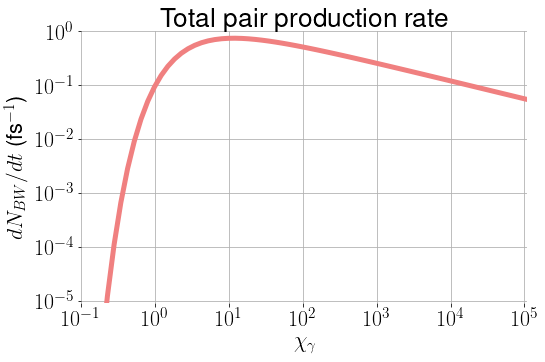

In [133]:
NUM_POINTS = 100
px = np.logspace(-1, 8.0, num=NUM_POINTS, base=10)*mec
p_phot = np.zeros([NUM_POINTS,3])
E_field = np.zeros([NUM_POINTS,3])
B_field = np.zeros([NUM_POINTS,3])
p_phot[:,0] = px
gamma_phot = np.linalg.norm(p_phot,axis=1)/mec
E_field[:,1] = get_electric_field(1e-6, 500)
chi_phot = comp_chi_phot(p_phot,E_field,B_field)

dNBW = BW_dN_dt(chi_phot,gamma_phot)
plt.rcParams.update({'font.size': 22})
fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.loglog(chi_phot, dNBW*1e-15, color='lightcoral', linewidth=5)
ax.set_xlabel('$\chi_{\gamma}$')
ax.set_ylabel('$dN_{BW}/dt$ (fs$^{-1}$)')
ax.set_title('Total pair production rate')
ax.set_ylim(9e-6, 1)
ax.set_xlim(1e-1,1.1e5)
ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
ax.set_xticks([1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5])
ax.set_frame_on(False)
ax.grid()
plt.show()

We can now investigate the distribution of the generated electrons (or, equivalently, of the generated positrons).
Note that the distrubution for the case $\chi_\gamma = 10$ is very similar to that for $\chi_\gamma = 20$ in
[Smilei documentation](https://smileipic.github.io/Smilei/multiphoton\_Breit\_Wheeler.html).

<ipython-input-132-05c6a7c72dda>:4: RuntimeWarning: invalid value encountered in double_scalars
  return integ.quad(lambda s: np.sqrt(s)*spe.kv(1./3., 2./3. * s**(3./2.)), x, np.inf)[0]
<ipython-input-132-05c6a7c72dda>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integ.quad(lambda s: np.sqrt(s)*spe.kv(1./3., 2./3. * s**(3./2.)), x, np.inf)[0]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
<ipython-input-132-05c6a7c72dda>:16: RuntimeWarning: invalid value encountered in multiply
  BW_inner(X) - (2.0 - chi_phot* X**(3./2.))*spe.kv(2./3., 2./3. * X**(3./2.)) )


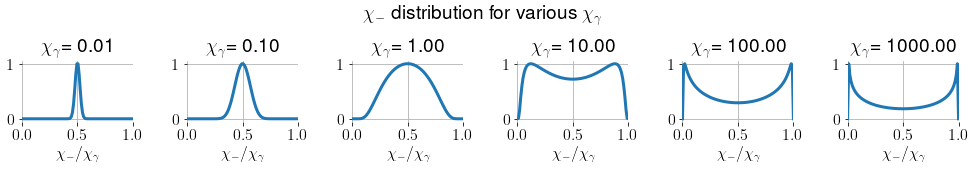

In [134]:
NUM_frac = 100
NUM_cases = 6
chi_gamma = px = np.logspace(-2.0, 3.0, num=NUM_cases, base=10)
prob = np.zeros([6,NUM_frac])
frac = np.linspace(0, 1.0, NUM_frac)
chi_ele = np.tensordot(chi_gamma, frac, axes=0)

prob = BW_F(chi_gamma[:,None], chi_ele)
prob_norm = prob/np.amax(prob, axis=1)[:,None]

plt.rcParams.update({'font.size': 16})
fig,ax=plt.subplots(ncols=NUM_cases,nrows=1,figsize=(14,2.2))
fig.suptitle('$\chi_-$ distribution for various $\chi_{\gamma}$', y = 1.1)

for j in range(NUM_cases):
    ax[j].plot(frac, prob_norm[j,:], linewidth=3)
    ax[j].set_xlim([0.0,1])
    ax[j].set_ylim([-0.05,1.05])
    ax[j].set_xlabel('$\chi_- / \chi_{\gamma}$')
    ax[j].set_title('$\chi_{\gamma}$' + '= {:6.2f}'.format(chi_gamma[j]) )
    ax[j].grid()
    ax[j].set_frame_on(False)
plt.tight_layout()
plt.show()

Same as above but with cumulative probability distributions:

<ipython-input-132-05c6a7c72dda>:4: RuntimeWarning: invalid value encountered in double_scalars
  return integ.quad(lambda s: np.sqrt(s)*spe.kv(1./3., 2./3. * s**(3./2.)), x, np.inf)[0]
<ipython-input-132-05c6a7c72dda>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integ.quad(lambda s: np.sqrt(s)*spe.kv(1./3., 2./3. * s**(3./2.)), x, np.inf)[0]
<ipython-input-132-05c6a7c72dda>:16: RuntimeWarning: invalid value encountered in double_scalars
  BW_inner(X) - (2.0 - chi_phot* X**(3./2.))*spe.kv(2./3., 2./3. * X**(3./2.)) )


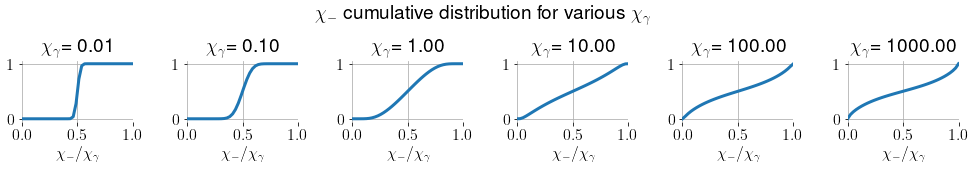

In [135]:
# ****************** WARNING: running this block will require several minutes! ****************************
NUM_frac = 40
NUM_cases = 6
chi_gamma = px = np.logspace(-2.0, 3.0, num=NUM_cases, base=10)
prob = np.zeros([6,NUM_frac])
frac = np.linspace(0, 1.0, NUM_frac)
chi_ele = np.tensordot(chi_gamma, frac, axes=0)

cum_prob = BW_P(chi_gamma[:,None], chi_ele)

plt.rcParams.update({'font.size': 16})
fig,ax=plt.subplots(ncols=NUM_cases,nrows=1,figsize=(14,2.2))
fig.suptitle('$\chi_-$ cumulative distribution for various $\chi_{\gamma}$', y = 1.1)

for j in range(NUM_cases):
    ax[j].plot(frac, cum_prob[j,:], linewidth=3)
    ax[j].set_xlim([0.0,1])
    ax[j].set_ylim([-0.05,1.05])
    ax[j].set_xlabel('$\chi_- / \chi_{\gamma}$')
    ax[j].set_title('$\chi_{\gamma}$' + '= {:6.2f}'.format(chi_gamma[j]) )
    ax[j].grid()
    ax[j].set_frame_on(False)
plt.tight_layout()
plt.show()

## Inverse Compton (IC) photon emission (a.k.a. Synchrotron-like radiation)

For the photon emission process, the model described in [Smilei documentation](https://smileipic.github.io/Smilei/radiation\_loss.html) (and also in  [RidgersJCP2014](https://doi.org/10.1016/j.jcp.2013.12.007) ) is adopted. We stress again that the notation in [RidgersJCP2014](https://doi.org/10.1016/j.jcp.2013.12.007) is different from that of the present document. Specifically: $\chi \rightarrow \eta$ and $\chi_{\gamma} \rightarrow 2\chi$.

The model is very similar to that used for BW pair generation.

We start from an expression for the differential photon emission cross section:

$$
\dfrac{d^2N}{dt d\chi_\gamma} = \frac{2}{3}\frac{\alpha m_e c^2}{\hbar}\frac{  \dfrac{\sqrt{3}}{2 \pi} (\chi_\gamma/\chi) \left[{ \int_{Y(\chi,\chi_\gamma/\chi)}^\infty K_{5/3}( s ) ds  + \frac{(\chi_\gamma/\chi)^2}{1-(\chi_\gamma/\chi)} K_{2/3}(Y(\chi,\chi_\gamma/\chi)) }\right]  }{\chi_\gamma}
$$
where 
$$
Y(\chi, \xi) = \dfrac{2}{3} \dfrac{\xi}{\chi(1-\xi)}
$$
In the following we will use $\xi = \chi_\gamma/\chi$ (obviously $\xi$ must be $<1$).

The previous formula can be re-written as:

$$
\dfrac{d^2N}{dt d\chi_\gamma} = \frac{2}{3}\frac{\alpha m_e c^2}{\hbar} \dfrac{S(\chi, \chi_\gamma/\chi)}{\chi_\gamma}
$$

We can obtain the total cross section by integrating over $\chi_\gamma$ from $0$ up to $\chi$.

$$
\dfrac{dN}{dt} = \frac{2}{3}\frac{\alpha m_e c^2}{\hbar} G(\chi)
$$

where

$$
 G(\chi) = \int_0^{\chi} \dfrac{S(\chi, u/\chi)}{u} du =  \int_0^{1} \dfrac{S(\chi, \xi)}{\xi} d\xi =  \int_0^{1}{ \dfrac{\dfrac{\sqrt{3}}{2 \pi} \xi \left[{ \int_{Y(\chi,\xi)}^\infty K_{5/3}( s ) ds  + \frac{\xi^2}{1-\xi} K_{2/3}(Y(\chi,\xi)) }\right]  }{\xi} d\xi}
$$


In order to determine the energies of the generated particles, it is worth to remind that we are working in the ultra-relativistic limit (i.e. the generated particles are ultra-relativistic). In this limit photons are emitted with a momentum exaclty aligned with that of the original particle. Thus, only the energy has to be determined. The ultra-relativistic limit allows writing $\gamma_\gamma = \gamma \xi$.

In order to determine the energy of the generated particles we extract $\chi_\gamma$ using the cumulative probability distribution:

$$
P(\chi, \chi_\gamma) = \frac{\int_0^{\chi_\gamma/\chi} S(\chi, u) du }{\int_0^{1} S(\chi, u)}
$$
 
In the PICSAR QED module lookup tables for $G$ and for the cumulative probability distribution $P$ are used.

In [136]:
#auxiliary function to calculate the inner integral in S
@np.vectorize
def IC_inner(y):
    return integ.quad(lambda s: spe.kv(5./3.,s), y, np.inf)[0] 

@np.vectorize
def IC_inner_alternative(y):
    ff = lambda x : np.exp(-y*(1+(4*x**2)/3)*np.sqrt(1+x*x/3))*(9+36*x**2 + 16*x**4)/(3 + 4*x**2)/np.sqrt(1+(x**2)/3)
    return integ.quad(ff, 0, np.inf)[0]/np.sqrt(3) 

def IC_Y(chi_ele, xi):
    res = np.zeros(np.shape(chi_ele))
    div = (chi_ele*(1-xi))
    div = np.where(np.logical_and(xi < 1, chi_ele != 0), div, 1.0);
    res = (2/3)*np.where(np.logical_and(xi < 1, chi_ele != 0), xi/div, np.inf)
    return res

def IC_S(chi_ele, xi):
    Y = IC_Y(chi_ele, xi)
    coeff = np.sqrt(3)/2.0/np.pi
    first = IC_inner_alternative(Y)
    div = np.where(xi == 1, 1.0, (1-xi)  )
    res = np.where(np.logical_or(xi == 1, xi == 0), 0.0, 
        coeff*xi*( first  + (xi**2 * spe.kv(2./3.,Y)*div )  ) )
    return res

def IC_SXI(chi_ele, xi):
    div = np.where(xi != 0, xi, 1.0)
    return np.where(xi != 0, IC_S(chi_ele, xi)/div, np.inf)

@np.vectorize
def IC_G(chi_ele):
    return integ.quad(lambda xi: IC_SXI(chi_ele, xi), 0, 1)[0]

def IC_dN_dt(chi_ele):
    coeff_IC = (2./3.) * fine_structure * me*c**2/hbar 
    return coeff_IC*IC_G(chi_ele)

def IC_d2N_dt_dchi(chi, chi_phot):    
    coeff_IC = (2./3.) * fine_structure * me*c**2/hbar 
    return coeff_IC*IC_S(chi, chi_phot/chi)/chi_phot

@np.vectorize
def IC_P(chi, chi_phot):
    div = 1.0/IC_G(chi)
    return div*integ.quad(lambda xi: IC_S(chi, xi)/xi, 0, chi_phot/chi)[0]

We can plot the total IC cross section.

<ipython-input-136-e6aac783e422>:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integ.quad(lambda s: spe.kv(5./3.,s), y, np.inf)[0]
<ipython-input-136-e6aac783e422>:28: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integ.quad(lambda xi: IC_SXI(chi_ele, xi), 0, 1)[0]
<ipython-input-136-e6aac783e422>:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purp

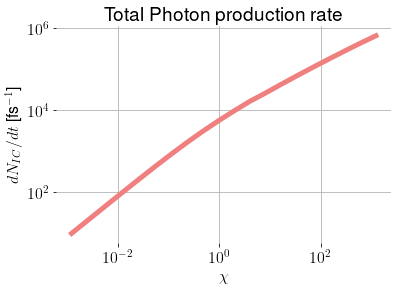

In [137]:
NUM_POINTS = 30
px = np.logspace(-3, 6.0, num=NUM_POINTS, base=10)*mec
p_ele = np.zeros([NUM_POINTS,3])
E_field = np.zeros([NUM_POINTS,3])
B_field = np.zeros([NUM_POINTS,3])
p_ele[:,0] = -px
gamma_ele = np.sqrt(1.0+np.sum(p_ele**2, axis=1)/mec**2)-1
E_field[:,1] = get_electric_field(1e-6, 500)
chi_ele = comp_chi_ele_pos(p_ele,E_field,B_field)

dNIC = IC_dN_dt(chi_ele)

plt.loglog(chi_ele, dNIC*1e-15, color='lightcoral', linewidth=5)
plt.xlabel('$\chi$')
plt.ylabel('$dN_{IC}/dt$ [fs$^{-1}$]')
plt.title('Total Photon production rate')
#plt.ylim(1e-3, 1e6)
#plt.xlim(1e-3,1e5)
plt.box(on=False)
plt.grid()
plt.show()

We can now investigate the distribution of the generated photons.
Results for $\chi = 0.01$ and $\chi = 1.0$ are similar to the distributions shown in [RidgersJCP2014](https://doi.org/10.1016/j.jcp.2013.12.007), figure A.7.

<ipython-input-136-e6aac783e422>:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integ.quad(lambda s: spe.kv(5./3.,s), y, np.inf)[0]


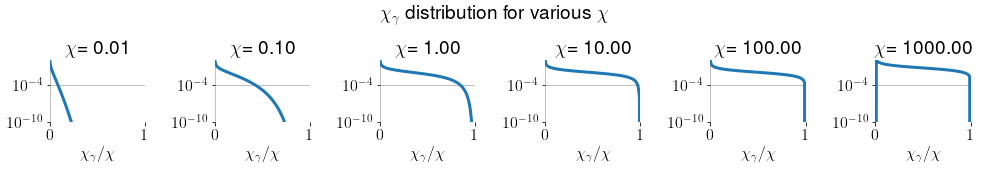

In [138]:
NUM_frac = 100
NUM_cases = 6
chi_ele = px = np.logspace(-2.0, 3.0, num=NUM_cases, base=10)
prob = np.zeros([6,NUM_frac])
frac = np.linspace(1e-3, 1.0, NUM_frac)
chi_phot = np.tensordot(chi_ele, frac, axes=0)

prob = IC_SXI(chi_ele[:,None], chi_phot/chi_ele[:,None])
prob_norm = prob/np.amax(prob, axis=1)[:,None]



plt.rcParams.update({'font.size': 16})
fig,ax=plt.subplots(ncols=NUM_cases,nrows=1,figsize=(14,2.2))
fig.suptitle('$\chi_\gamma$ distribution for various $\chi$', y = 1.1)

for j in range(NUM_cases):
    ax[j].semilogy(frac, prob_norm[j,:], linewidth=3)
    ax[j].set_xlim([0,1])
    ax[j].set_ylim([1e-10,1.2])
    ax[j].set_xlabel('$\chi_\gamma / \chi$')
    ax[j].set_title('$\chi$' + '= {:6.2f}'.format(chi_ele[j]) )
    ax[j].grid()
    ax[j].set_frame_on(False)
plt.tight_layout()
plt.show()

Plotting cumulative probability distribution takes too long!

## Schwinger (SH) pair generation

An expression for the Schwinger pair production rate can be found in [NarozhnyPRA2004](https://doi.org/10.1134/1.1830652) rewritten in SI units, the pair production rate per unit volume is:

$$
\dfrac{d^2N}{dt dV} = \dfrac{e^2 E_s^2}{4 \pi^2 \hbar^2 c} \epsilon \eta \coth{\left({\dfrac{\pi \eta}{\epsilon}}\right)}\exp{\left({-\dfrac{\pi}{\epsilon}}\right)}
$$

where $e$ is the elementary charge, $E_s$ is the Schwinger field, $\epsilon = \mathcal{E}/E_s$ and $\eta = \mathcal{H}/E_s$. $\mathcal{E}$ and $\mathcal{H}$ are given by:

$$
\mathcal{E} = \sqrt{\sqrt{\mathcal{F}^2 + \mathcal{G}^2} + \mathcal{F}} \\
\mathcal{H} = \sqrt{\sqrt{\mathcal{F}^2 + \mathcal{G}^2} - \mathcal{F}} \\
$$

$\mathcal{F}$ and $\mathcal{G}$ are the invariants of the electromagnetic field and are equal to:

$$
\mathcal{F} = (\mathbf{E}^2 - c^2 \mathbf{B}^2)/2 \\
\mathcal{G} = c \mathbf{E} \cdot \mathbf{B} \\
$$ 


In [139]:
#E and B are in SI units and have shape (N,3)
def SH_d2N_dtdV(E, B):
    ff = (np.sum(E**2, axis=1) - c**2 * np.sum(B**2, axis=1))/2
    gg = c*np.einsum('ij,ij->i',E,B)
    tt = np.sqrt(ff**2 + gg**2)
    epsi = np.sqrt(tt + ff)/E_s
    eta = np.sqrt(tt - ff)/E_s
    
    coeff = (qe**2 * E_s**2)/(4* np.pi**2 * hbar**2 * c)
    
    res = np.zeros(E.shape[0])
    
    def f1(epsi):
        return epsi*(epsi/np.pi)*np.exp(-np.pi/epsi)
    
    def f2(epsi, eta):
        return epsi*eta *(1./np.tanh(np.pi*eta/epsi))*np.exp(-np.pi/epsi)
    
    i1 = np.logical_and(epsi != 0, eta == 0)
    i2 = np.logical_and(epsi != 0, eta != 0)
    res[i1] = coeff *f1(epsi[i1])
    res[i2] = coeff *f2(epsi[i2],eta[i2])

    return res

#E and B are in SI units and have shape (3)
def single_SH_d2N_dtdV(E,B):
    return SH_d2N_dtdV(E[None,:], B[None,:])[0]

We can now perform some tests, considering a case where there is only an eletric field

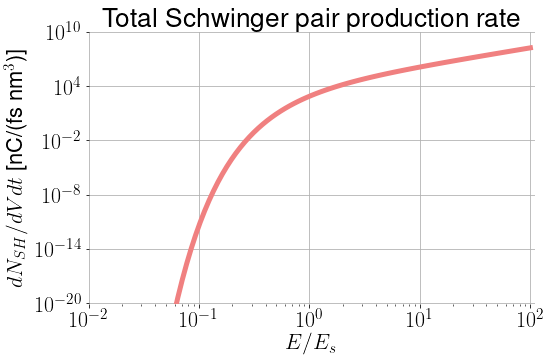

In [140]:
NUM_POINTS = 100
ex = np.logspace(-2, 2.0, num=NUM_POINTS, base=10)*E_s
E_field = np.zeros([NUM_POINTS,3])
B_field = np.zeros([NUM_POINTS,3])
E_field[:,0] = ex

dV= (1.0e-9)**3 # 1 nm^3
dt = 1.0e-15 # 1fs

dN = SH_d2N_dtdV(E_field,B_field)*dV*dt

plt.rcParams.update({'font.size': 22})
fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.loglog(ex/E_s, dN*qe*1e9, color='lightcoral', linewidth=5)
ax.set_xlabel('$E/E_s$')
ax.set_ylabel('$dN_{SH}/dVdt$ [nC/(fs nm$^{3}$)]')
ax.set_title('Total Schwinger pair production rate')
ax.set_xlim(1e-2,1.1e2)
ax.set_ylim(9e-21,1e10)
ax.set_yticks([1e-20,1e-14, 1e-8, 1e-2, 1e4, 1e10])
ax.set_frame_on(False)
ax.grid()
plt.show()

In [141]:
print("Pair production rate at E = E_s is {:6.2f} nC/nm^3/fs".format(single_SH_d2N_dtdV(np.array([E_s,0,0]),np.array([0,0,0]))*1e-27*1.6e-10*1.0e-15))

Pair production rate at E = E_s is 751.60 nC/nm^3/fs
